In [10]:
using SeisNoise, PyPlot, CUDA, Glob, HDF5, Combinatorics, Random, Statistics, ImageFiltering, FFTW, JLD2, Dates
import SeisNoise: NoiseData
import SeisIO: read_nodal, NodalData, InstrumentPosition, InstrumentResponse, show_str, show_t, show_x, show_os
import FFTW: rfft, irfft
import DSP: hilbert
import Images: findlocalmaxima
import Base:show, size, summary
import PyCall
import SeisDvv
import Dates
import FiniteDifferences
import CSV
using NetCDF
using DataFrames
include("Types.jl")
include("Nodal.jl")
include("Misc.jl")
include("Workflow.jl")

workflow (generic function with 6 methods)

In [ ]:
# write code to rerun all dvv while skipping the shots (isolate them correctly in time!)
# make SURE x-axis time handling is exactly correct
# remake all plots
# make composite plotss

In [3]:
function collect_autocorrs(files,datetimes,restack_interval,ns,ncorr,bands)

    # get start and end datetime
    start_datetime = datetimes[1]-Minute(datetimes[1])-Second(datetimes[1])
    end_datetime = datetimes[end]+Hour(1)-Minute(datetimes[end])-Second(datetimes[end])
    
    # get times to restack
    restack_interval = Minute(restack_interval)
    restack_lims = start_datetime:restack_interval:end_datetime
    restack_times = collect(restack_lims[2:end])

    # get a list of files that should be stacked together
    stack_files = []
    for i=1:size(restack_lims,1)-1
        stack_ind = (datetimes .> restack_lims[i]) .& (datetimes .< restack_lims[i+1])
        append!(stack_files,[files[stack_ind]])
    end
    nstacks = size(stack_files,1)

    # make output data matrix
    all_autocorrs = zeros(ns,ncorr,nstacks,size(bands,1))

    # set a useful counter and read first file
    C = JLD2.load(files[1])["NodalCorrData"]
    for i=1:size(stack_files,1)

        # if there's not a gap
        if size(stack_files[i],1) > 0

            # stack each file
            for j=1:size(stack_files[i],1)

                try
                    if j == 1
                        C = JLD2.load(stack_files[i][j])["NodalCorrData"]
                    else
                        C.corr += JLD2.load(stack_files[i][j])["NodalCorrData"].corr
                    end
                catch error
                    bt = backtrace()
                    msg = sprint(showerror, error, bt)
                    error_string = "\nError on file: "*files[i]*"\n"*msg*"\n"
                    println(error_string)
                end
            end

            # load stack into data structure
            for k=1:size(bands,1)

                # postprocessing
                C_filt = deepcopy(C)
                clean_up!(C_filt,bands[k,1],bands[k,2])
                abs_max!(C_filt)

                # fill output
                all_autocorrs[:,:,i,k] = C_filt.corr
            end

        end
    end

    return restack_times, all_autocorrs
end



function compute_stretching_dvv(autocorrs,bands,t_lims,dv_lims,ntrial,gain_correct,gain_correction=[])
    
    # handle time stuff
    t = range(0,1,size(autocorrs,1))
    t_win = findall(t->t<=t_lims[2] && t>=t_lims[1], t);

    # make output containers
    n_bands = size(bands,1)
    dvv = zeros(size(autocorrs,2),size(autocorrs,3),n_bands)
    
    # get number of empty stacks
    num_empty = sum(autocorrs[1,1,:,1] .== 0)

    # iterate through channel
    for c=1:size(autocorrs,2)

        # iterate through each frequency band
        for j=1:n_bands

            # get reference waveform (gain-corrected average autocorrelation at this channel)
            ref_s = sum(autocorrs[:,c,:,j],dims=2)/(size(autocorrs,3)+1-num_empty)
            if gain_correct == true
                ref_s = gain_correction .* ref_s
            end
            
            # normalize and demean with respect to desired window
            ref_s = ref_s .- mean(ref_s[t_win])
            ref_s = ref_s ./ maximum(abs.(ref_s[t_win]))

            # iterate through each hour
            for i=1:size(autocorrs,3)

                # check if empty
                if sum(autocorrs[:,c,i,j]) != 0

                    # get gain-corrected waveform to compare with reference
                    s = autocorrs[:,c,i,j]
                    if gain_correct == true
                        s = s.* gain_correction
                    end
                    
                    # normalize and demean with respect to desired window
                    s = s .- mean(s[t_win])
                    s = s ./ maximum(abs.(s[t_win]))
                    
                    # calculate dv/v
                    dvv[c,i,j],cc_ts,cdp_Ts,eps_ts,err_ts,allC_ts = SeisDvv.stretching(ref_s,s,t,t_win,bands[j,1],bands[j,2],dvmin=dv_lims[1],dvmax=dv_lims[2],ntrial=ntrial);
                end
            end
        end
    end
    
    return dvv
end

compute_stretching_dvv (generic function with 2 methods)

In [ ]:
"

Set some parameters for autocorrelation consolidation

"

# frequency bands to return
bands = [[10. 13.];]

# set number of samples and correlations
ns = 801
ncorr = 3090

# make a helper function to get files and datetimes 
function get_files_and_datetimes(cmin,cmax)

    # list files
    path = string("/fd1/solinger/correlations/fk_",cmin,"_",cmax,"/no_whitening/10_min/icequakes_removed/")
    files = glob("*.jld2",path)
    files = files[BitVector(1 .- contains.(files,"autocorrelation"))]
    files = files[BitVector(1 .- contains.(files,"datetimes"))]
    files = files[BitVector(1 .- contains.(files,"dv"))]

    # get datetimes of each file
    datetimes = []
    for i=1:size(files,1)
        datetimes = vcat(datetimes,DateTime(string("2019"*split(split(files[i],"_2019")[2],".jld2")[1])))
    end
    
    return files, path, datetimes
end

In [ ]:
"

Read and preprocess autocorrelations (P-waves, 10 minute stack)

"

# processing parameters
cmin,cmax = 3500,4250

# get files and datetimes
files, path, datetimes = get_files_and_datetimes(cmin,cmax)

# restack time
restack_interval = 10

# get autocorrs
restack_times, all_autocorrs = collect_autocorrs(files,datetimes,restack_interval,ns,ncorr,bands)

# save the autocorrelations and datetime information
fname = string(path,"autocorrelations_",Int(bands[1,1]),"-",Int(bands[end,2]),"Hz_",restack_interval,"_min_stack.jld2")
JLD2.save(fname,Dict("autocorrs"=>all_autocorrs))
fname = string(path,"datetimes_",restack_interval,"_min_stack.jld2")
JLD2.save(fname,Dict("datetimes"=>collect(restack_times)))

In [ ]:
"

Read and preprocess autocorrelations (P-waves, 60 minute stack)

"

# restack time
restack_interval = 60

# get autocorrs
restack_times, all_autocorrs = collect_autocorrs(files,datetimes,restack_interval,ns,ncorr,bands)

# save the autocorrelations
fname = string(path,"autocorrelations_",Int(bands[1,1]),"-",Int(bands[end,2]),"Hz_",restack_interval,"_min_stack.jld2")
JLD2.save(fname,Dict("autocorrs"=>all_autocorrs))
fname = string(path,"datetimes_",restack_interval,"_min_stack.jld2")
JLD2.save(fname,Dict("datetimes"=>collect(restack_times)))

In [ ]:
"

Read and preprocess autocorrelations (S-waves, 10 minute stack)

"

# processing parameters
cmin,cmax = 1500,2250

# restack time
restack_interval = 10

# get files and datetimes
files, path, datetimes = get_files_and_datetimes(cmin,cmax)

# get autocorrs
restack_times, all_autocorrs = collect_autocorrs(files,datetimes,restack_interval,ns,ncorr,bands)

# save the autocorrelations
fname = string(path,"autocorrelations_",Int(bands[1,1]),"-",Int(bands[end,2]),"Hz_",restack_interval,"_min_stack.jld2")
JLD2.save(fname,Dict("autocorrs"=>all_autocorrs))
fname = string(path,"datetimes_",restack_interval,"_min_stack.jld2")
JLD2.save(fname,Dict("datetimes"=>collect(restack_times)))

In [ ]:
"

Read and preprocess autocorrelations (S-waves, 60 minute stack)

"

# restack time
restack_interval = 60

# get autocorrs
restack_times, all_autocorrs = collect_autocorrs(files,datetimes,restack_interval,ns,ncorr,bands)

# save the autocorrelations
fname = string(path,"autocorrelations_",Int(bands[1,1]),"-",Int(bands[end,2]),"Hz_",restack_interval,"_min_stack.jld2")
JLD2.save(fname,Dict("autocorrs"=>all_autocorrs))
fname = string(path,"datetimes_",restack_interval,"_min_stack.jld2")
JLD2.save(fname,Dict("datetimes"=>collect(restack_times)))

In [ ]:
"

Visualize the autocorrelation functions

"

# choose which fk band
cmin = 3500
cmax = 4250

# choose which stacking
restack_interval = 60

# choose frequency bands
bands = [[10. 13.];]

# load autocorrelations
path = string("/fd1/solinger/correlations/fk_",cmin,"_",cmax,"/no_whitening/10_min/icequakes_removed/")
fname = string(path,"autocorrelations_",Int(bands[1,1]),"-",Int(bands[end,2]),"Hz_",restack_interval,"_min_stack.jld2")
all_autocorrs = JLD2.load(fname)["autocorrs"]
zero_ind = size(all_autocorrs,1)÷2+1
pos_autocorrs = all_autocorrs[zero_ind:end,:,:,:]

# plot autocorrelations at depth for a single time step
fig,ax = plt.subplots(2,1,figsize=(10,10))
extent = [0,1,1047,0]
ax[1].imshow(pos_autocorrs[:,1:1030,58,1]',aspect="auto",cmap="seismic",extent=extent)
ax[1].set_ylabel("Depth")
ax[1].set_xlabel("Lag time (s)")

# plot autocorrelations through time for a single channel
extent = [0,74,0,1]
ax[2].imshow(pos_autocorrs[:,200,:,1],aspect="auto",cmap="seismic",origin="lower")
ax[2].set_ylabel("Lag time (s)")
ax[2].set_xlabel("Time (hour)")
plt.tight_layout()

In [ ]:
"

Identify data gaps

"

# choose run 
path_1khz = "/1-fnp/petasaur/p-wd03/greenland/Store Glacier DAS data/"
path_resampled = "/1-fnp/pnwstore1/p-wd05/greenland/data/resampled"
files_1khz = glob("1kHz/*",path_1khz)
files_resampled = glob("*",path_resampled)
files = cat(files_1khz,files_resampled,dims=1)

# get datetimes of each file
file_datetimes = []
for i=1:size(files,1)
    file_datetimes = vcat(file_datetimes,DateTime(split(split(files[i],"AQ_")[2],".")[1],dateformat"yymmddHHMMSS"))
end

# get time delta
diff_vec = diff(file_datetimes)
diff_vec_sec = []
for i=1:size(diff_vec,1)
    diff_vec_sec = vcat(diff_vec_sec,diff_vec[i].value/1000)
end

# make a crude plot
fig,ax = plt.subplots(1,1,figsize=(10,5))
plt.scatter(file_datetimes[2:end],diff_vec_sec)
plt.yscale("log")

In [5]:
"

Set common parameters for dv/v calculation

"

# choose frequency bands
bands = [[10. 13.];]
n_bands = size(bands,1)
band = 1

# set gain correction function
gain_correct = "none"

# set parameters for all dv/v methods
method = "stretching"

# set stretching parameters
dvlims = [-0.2,0.2]
ntrial = 100

# choose first hour to consider (exclude noisy period at start of deployment)
start_time = DateTime(2019,7,6,10)

# set parameters for all dv/v runs
clims = [[3500,4250],[1500,2250]]
restack_intervals = [60,10]
sides = ["pos","neg"]
tlims = [[0.0,0.3],[0.3,0.8]]
parameters = collect(Iterators.product(clims,sides,tlims,restack_intervals))

2×2×2×2 Array{Tuple{Vector{Int64}, String, Vector{Float64}, Int64}, 4}:
[:, :, 1, 1] =
 ([3500, 4250], "pos", [0.0, 0.3], 60)  ([3500, 4250], "neg", [0.0, 0.3], 60)
 ([1500, 2250], "pos", [0.0, 0.3], 60)  ([1500, 2250], "neg", [0.0, 0.3], 60)

[:, :, 2, 1] =
 ([3500, 4250], "pos", [0.3, 0.8], 60)  ([3500, 4250], "neg", [0.3, 0.8], 60)
 ([1500, 2250], "pos", [0.3, 0.8], 60)  ([1500, 2250], "neg", [0.3, 0.8], 60)

[:, :, 1, 2] =
 ([3500, 4250], "pos", [0.0, 0.3], 10)  ([3500, 4250], "neg", [0.0, 0.3], 10)
 ([1500, 2250], "pos", [0.0, 0.3], 10)  ([1500, 2250], "neg", [0.0, 0.3], 10)

[:, :, 2, 2] =
 ([3500, 4250], "pos", [0.3, 0.8], 10)  ([3500, 4250], "neg", [0.3, 0.8], 10)
 ([1500, 2250], "pos", [0.3, 0.8], 10)  ([1500, 2250], "neg", [0.3, 0.8], 10)

In [5]:
"

Compute autocorrelations for each set of parameters 
(P wave / S wave, positive / negative lag, coda / ballistic, 60 / 10 minute stack)

"

# iterate through list of parameters
for parameter in parameters
    
    # get parameters
    clim = parameter[1]
    side = parameter[2]
    tlim = parameter[3]
    restack_interval = parameter[4]

    # choose first hour to consider (exclude noisy period at start of deployment)
    start_time = DateTime(2019,7,6,10)

    # load autocorrelations
    path = string("/fd1/solinger/correlations/fk_",clim[1],"_",clim[2],"/no_whitening/10_min/icequakes_removed/")
    fname = string(path,"autocorrelations_",Int(bands[1,1]),"-",Int(bands[end,2]),"Hz_",restack_interval,"_min_stack.jld2")
    autocorrs = JLD2.load(fname)["autocorrs"]

    # get correct side
    zero_ind = size(autocorrs,1)÷2+1
    if side == "pos"
        autocorrs = autocorrs[zero_ind:end,:,:,:]
    elseif side == "neg"
        autocorrs = autocorrs[1:zero_ind,:,:,:]
        autocorrs = reverse(autocorrs,dims=1)
    end

    # get index of first correlation
    fname = string(path,"datetimes_",restack_interval,"_min_stack.jld2")
    datetimes = JLD2.load(fname)["datetimes"]
    start_ind = findfirst(datetimes .> start_time)

    # run stretching dvv computation
    dvv = compute_stretching_dvv(autocorrs[:,:,start_ind:end,:],bands,tlim,dvlims,ntrial,gain_correct)

    # save results
    fname = string(path,"auto_dvv_",method,"_",Int(bands[1,1]),"-",Int(bands[end,2]),"Hz_",tlim[1],"-",tlim[2],"s_",restack_interval,"_min_",side,".jld2")
    JLD2.save(fname,Dict("dvv"=>dvv))
    
    # give output
    println("Saved ",fname)
end

0.0:0.0025:0.3
Saved /fd1/solinger/correlations/fk_3500_4250/no_whitening/10_min/icequakes_removed/auto_dvv_stretching_10-13Hz_0.0-0.3s_60_min_pos.jld2
0.0:0.0025:0.3
Saved /fd1/solinger/correlations/fk_1500_2250/no_whitening/10_min/icequakes_removed/auto_dvv_stretching_10-13Hz_0.0-0.3s_60_min_pos.jld2
0.0:0.0025:0.3
Saved /fd1/solinger/correlations/fk_3500_4250/no_whitening/10_min/icequakes_removed/auto_dvv_stretching_10-13Hz_0.0-0.3s_60_min_neg.jld2
0.0:0.0025:0.3
Saved /fd1/solinger/correlations/fk_1500_2250/no_whitening/10_min/icequakes_removed/auto_dvv_stretching_10-13Hz_0.0-0.3s_60_min_neg.jld2
0.3:0.0025:0.8
Saved /fd1/solinger/correlations/fk_3500_4250/no_whitening/10_min/icequakes_removed/auto_dvv_stretching_10-13Hz_0.3-0.8s_60_min_pos.jld2
0.3:0.0025:0.8
Saved /fd1/solinger/correlations/fk_1500_2250/no_whitening/10_min/icequakes_removed/auto_dvv_stretching_10-13Hz_0.3-0.8s_60_min_pos.jld2
0.3:0.0025:0.8
Saved /fd1/solinger/correlations/fk_3500_4250/no_whitening/10_min/icequak

In [27]:
"

Stack dv/v

"

# choose which fk band
cmin = 3500
cmax = 4250

# choose which time window
t_win = [0.3,0.8]

# choose which stacking
restack_interval = 60

# choose which band (probably 1)
band = 1

# set path
path = string("/fd1/solinger/correlations/fk_",cmin,"_",cmax,"/no_whitening/10_min/icequakes_removed/")

# load dv/v from positive autocorrelations
fname = string(path,"auto_dvv_",method,"_",Int(bands[1,1]),"-",Int(bands[end,2]),"Hz_",t_win[1],"-",t_win[2],"s_",restack_interval,"_min_pos.jld2")
auto_dvv_pos = JLD2.load(fname)["dvv"]

# load dv/v from negative autocorrelations
fname = string(path,"auto_dvv_",method,"_",Int(bands[1,1]),"-",Int(bands[end,2]),"Hz_",t_win[1],"-",t_win[2],"s_",restack_interval,"_min_neg.jld2")
auto_dvv_neg = JLD2.load(fname)["dvv"]

# stack downgoing, upgoing, and cross autocorrelations
auto_dvv = auto_dvv_pos[1:1030,:,band] .+ auto_dvv_pos[1031:2060,:,band] .+ auto_dvv_pos[2061:3090,:,band]
auto_dvv = auto_dvv .+ auto_dvv_neg[1:1030,:,band] .+ auto_dvv_neg[1031:2060,:,band] .+ auto_dvv_neg[2061:3090,:,band]
auto_dvv = auto_dvv ./ 6

# read stack datetime info
fname = string(path,"datetimes_",restack_interval,"_min_stack.jld2")
datetimes = JLD2.load(fname)["datetimes"]

78-element Vector{DateTime}:
 2019-07-05T14:00:00
 2019-07-05T15:00:00
 2019-07-05T16:00:00
 2019-07-05T17:00:00
 2019-07-05T18:00:00
 2019-07-05T19:00:00
 2019-07-05T20:00:00
 2019-07-05T21:00:00
 2019-07-05T22:00:00
 2019-07-05T23:00:00
 2019-07-06T00:00:00
 2019-07-06T01:00:00
 2019-07-06T02:00:00
 ⋮
 2019-07-08T08:00:00
 2019-07-08T09:00:00
 2019-07-08T10:00:00
 2019-07-08T11:00:00
 2019-07-08T12:00:00
 2019-07-08T13:00:00
 2019-07-08T14:00:00
 2019-07-08T15:00:00
 2019-07-08T16:00:00
 2019-07-08T17:00:00
 2019-07-08T18:00:00
 2019-07-08T19:00:00

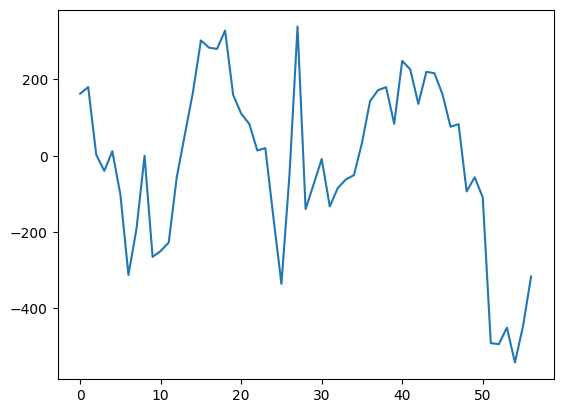

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff30b8d5080>

In [28]:
plt.plot(sum(auto_dvv,dims=1)[1,:])

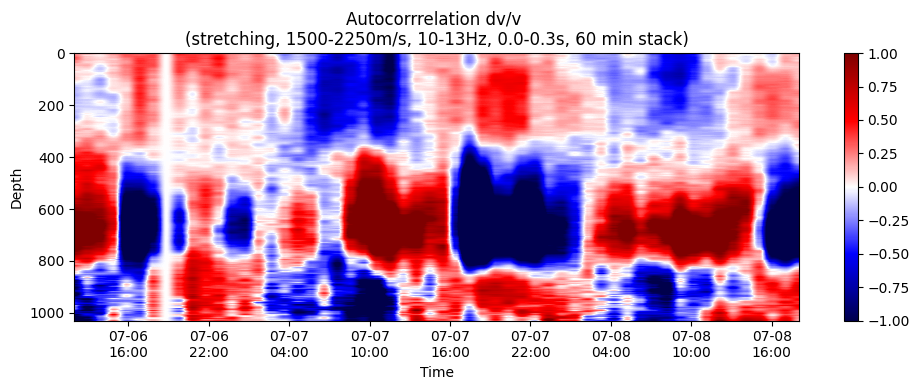

In [7]:
"

Visualize dv/v

"

# get time axis in local time
datestring = []
for i=1:size(datetimes,1)
    datestring = vcat(datestring,Dates.format(datetimes[i],"mm-dd\nHH:MM"))
end

# make color plot 
fig,ax = plt.subplots(1,1,figsize=(10,4))
c1 = ax.imshow(auto_dvv[:,:,band],aspect="auto",cmap="seismic",vmin=-1,vmax=1)
ax.set_ylabel("Depth")
ax.set_xlabel("Time")

# handle date axis
start_time = DateTime(2019,7,6,10)
start_ind = findfirst(datetimes .> start_time)
datelabels = [start_time+Hour(6*i) for i=0:9]
datestring = []
for i=1:size(datelabels,1)
    datestring = vcat(datestring,Dates.format(datelabels[i],"mm-dd\nHH:MM"))
end

# set xlims on all plots
xticks = (datelabels.-datetimes[start_ind])./(datetimes[end].-datetimes[start_ind]).*size(auto_dvv,2)
ax.set_xticks(xticks)
ax.set_xticklabels(datestring)
lim_ind = [findfirst(abs.(auto_dvv[1,:,1]) .> 0),size(auto_dvv,2)-1]
ax.set_xlim(lim_ind)

title = string("Autocorrrelation dv/v \n(",method,", ",cmin,"-",cmax,"m/s, ",Int(bands[band,1]),"-",Int(bands[band,2]),"Hz, ",t_win[1],"-",t_win[2],"s, ",restack_interval," min stack)")
ax.set_title(title)
plt.colorbar(c1)
plt.tight_layout()

fname = string("dvv_",method,"_fk_",cmin,"_",cmax,"_",Int(bands[band,1]),"-",Int(bands[band,2]),"Hz_",t_win[1],"-",t_win[2],"s_",restack_interval,"_min_stack.png")
plt.savefig("../figures/dvv/"*fname,dpi=100)
plt.show()

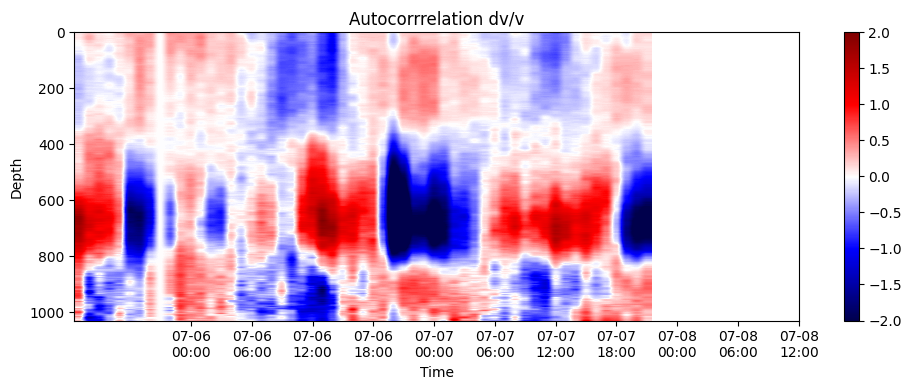

In [8]:
"

Visualize dv/v

"

# get time axis in local time
datestring = []
for i=1:size(datetimes,1)
    datestring = vcat(datestring,Dates.format(datetimes[i],"mm-dd\nHH:MM"))
end

# make color plot 
fig,ax = plt.subplots(1,1,figsize=(10,4))
c1 = ax.imshow(auto_dvv[:,:,band],aspect="auto",cmap="seismic",vmin=-2,vmax=2)
ax.set_ylabel("Depth")
ax.set_xlabel("Time")
#xticks = [2,8,14,20,26,32,38,44,50,56,62,68]
xticks = [11,17,23,29,35,41,47,53,59,65,71]
xticklabels = datestring[xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_title("Autocorrrelation dv/v")
plt.colorbar(c1)
plt.tight_layout()
fname = string("dvv_",method,"_fk_",cmin,"_",cmax,"_",Int(bands[band,1]),"-",Int(bands[band,2]),"Hz_0.0-0.3s_60_min_pos.jld2")
#plt.savefig("../figures/dvv/"*fname,dpi=100)
plt.show()

No handles with labels found to put in legend.
sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


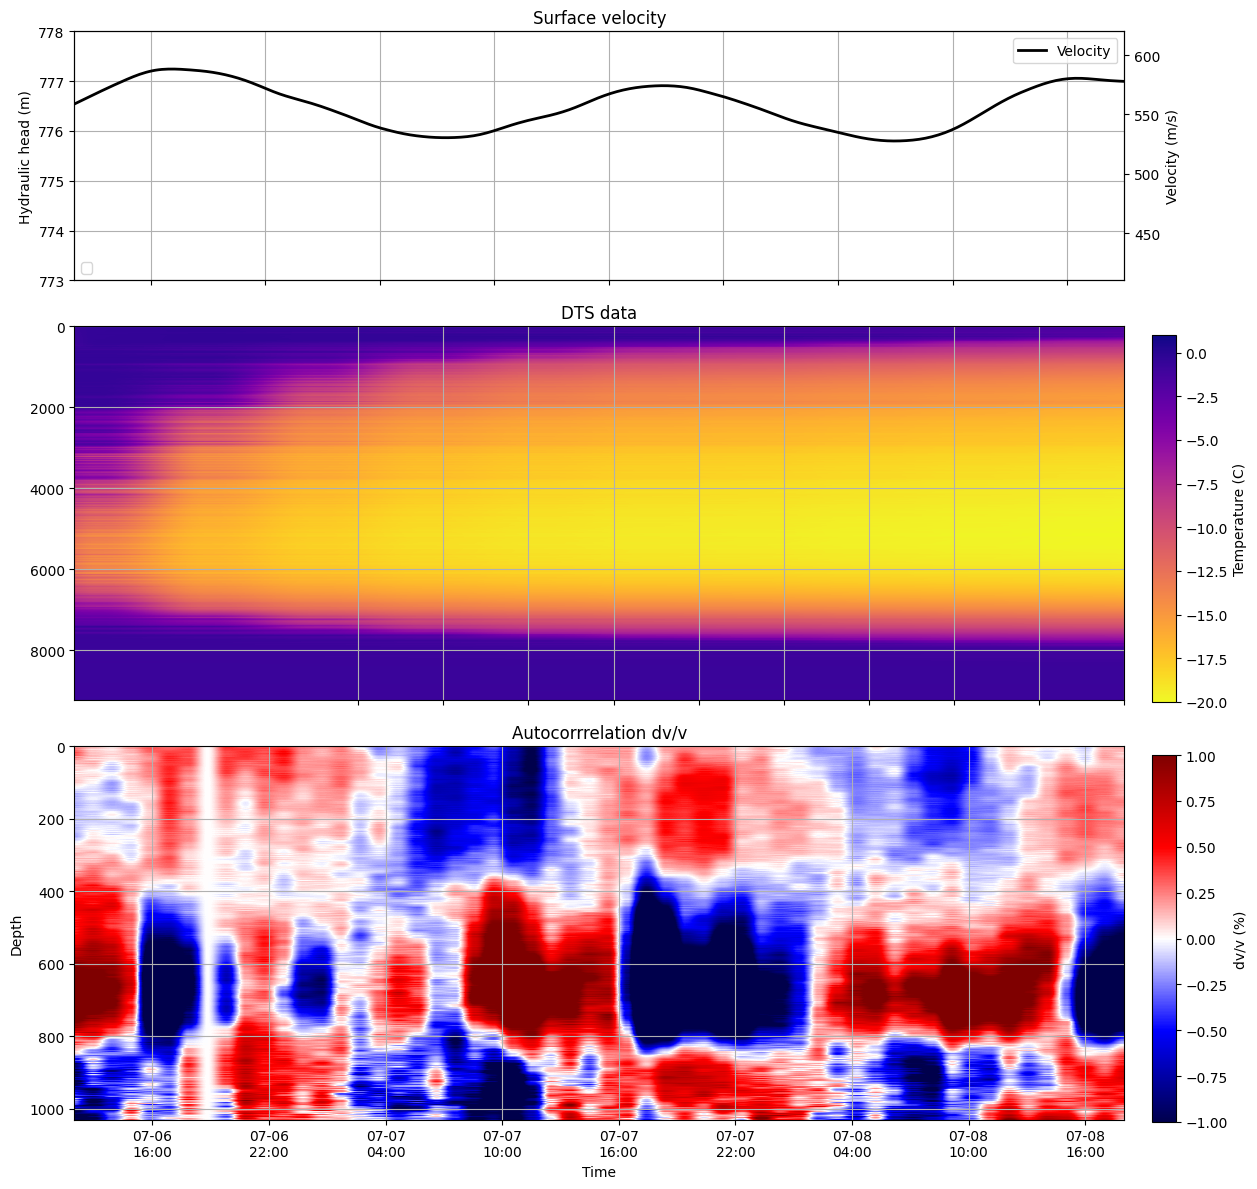

In [9]:
"

Make superplot with all the data

need to add icequakes
need to get ticks at the same points so we can do grid(true)
fix depth axes
add colobars
verifying timing stuff is correct for all
probably will want to move a dts profile to the right of the dv/v rather than imshow since it's basically constant

"

# read water pressure
p_BH19c = DataFrame(CSV.File("../borehole_data/BH19c_pressure.csv"))
format = "yyyy-mm-dd HH:MM:SS"
t_BH19c =  [DateTime(p_BH19c[i,1],format) for i in range(1,size(p_BH19c,1))]

# read BH19e pressure and ice velocity
p_BH19e = DataFrame(CSV.File("../borehole_data/BH19e_pressure.csv"))
t_BH19e =  [DateTime(p_BH19e[i,1],format) for i in range(1,size(p_BH19e,1))]
gnss = DataFrame(CSV.File("../borehole_data/R30_GNSS.csv"))
t_gnss = [DateTime(gnss[i,1],format) for i in range(1,size(gnss,1))]
mean_vel = Statistics.mean(gnss[80:end,6])

# read DTS data
dts = ncread("../borehole_data/Store_Glacier_DTS/processed_data/ch1_full_processed.nc","tmpw_central")'
t_dts = ncread("../borehole_data/Store_Glacier_DTS/processed_data/ch1_full_processed.nc","t")
z_dts = ncread("../borehole_data/Store_Glacier_DTS/processed_data/ch1_full_processed.nc","z")
dts = dts[1850:end,:]
z_dts = z_dts[1850:end].-z_dts[1850]
datetime_dts = [DateTime(2019,7,5,8)+Hour(i) for i in t_dts]

# handle date axis
datelabels = [start_time+Hour(6*i) for i=0:9]
datestring = []
for i=1:size(datelabels,1)
    datestring = vcat(datestring,Dates.format(datelabels[i],"mm-dd\nHH:MM"))
end

# plot borehole pressure
fig,ax = plt.subplots(3,1,figsize = (12,12),gridspec_kw=Dict("height_ratios" => [2,3,3]))
#ax[1].plot(t_BH19c,p_BH19c[:,3],label="Pressure (BH19c)",c="mediumvioletred",linestyle="--",linewidth=4)
#ax[1].plot(t_BH19e-Dates.Day(10),p_BH19e[:,3],label="Pressure (BH19e)",c="darkcyan",linestyle="--",linewidth=4)
ax[1].set_ylim(773,778)
ax[1].set_ylabel("Hydraulic head (m)")
ax[1].set_title("Basal water pressure")#and surface velocity")
ax[1].set_title("Surface velocity")#and surface velocity")

# plot surface velocity
ax2 = ax[1].twinx()
ax2.plot(t_gnss.-Dates.Day(16),gnss[:,6],label="Velocity",c="k",linewidth=2)
ax2.set_ylabel("Velocity (m/s)")
ax2.set_ylim(410,620)
ax2.legend()
ax[1].legend(loc=3)

# plot DTS data
c = ax[2].imshow(dts,aspect="auto",cmap="plasma_r",vmin=-20,vmax=1)
ax[2].set_title("DTS data")

# plot stacked dv/v
c1 = ax[3].imshow(auto_dvv[:,:,band],aspect="auto",cmap="seismic",vmin=-1,vmax=1)
ax[3].set_ylabel("Depth")
ax[3].set_xlabel("Time")
xticks = (datelabels.-datetimes[start_ind])./(datetimes[end].-datetimes[start_ind]).*size(auto_dvv,2)
ax[3].set_xticks(xticks)
ax[3].set_xticklabels(datestring)
ax[3].set_title("Autocorrrelation dv/v")
starthour = findfirst(abs.(auto_dvv[1,:,1]) .> 0)

# set xlims on all plots
lim_ind = [findfirst(abs.(auto_dvv[1,:,1]) .> 0),size(auto_dvv,2)-1]
ax[1].set_xlim(datetimes[lim_ind[1]],datetimes[lim_ind[2]])
ax[1].set_xticklabels([]) 
ax[2].set_xticklabels([]) 
ax[3].set_xlim(lim_ind)
ax[1].grid(true) 
ax[2].grid(true)  
ax[3].grid(true) 
start_dur = datetimes[lim_ind[1]]-datetime_dts[1]
end_dur = datetimes[lim_ind[2]]-datetime_dts[1]
dur = datetime_dts[end]-datetime_dts[1]
plot_start = start_dur/dur*size(t_dts,1)
plot_stop = end_dur/dur*size(t_dts,1)
ax[2].set_xlim([plot_start,plot_stop])

# take care of grid for DTS plot
ax[2].set_xticks((datelabels.-datetime_dts[1])./dur.*size(t_dts,1))

# colorbars
box = ax[3].get_position()
axColor = plt.axes([box.x0*1.2 + box.width*1.05, box.y0-0.05, 0.02, box.height*1.2])
cbar = plt.colorbar(c1, cax = axColor, orientation="vertical")
cbar.set_label("dv/v (%)")
box = ax[2].get_position()
axColor = plt.axes([box.x0*1.2 + box.width*1.05, box.y0, 0.02, box.height*1.2])
cbar = plt.colorbar(c, cax = axColor, orientation="vertical")
cbar.set_label("Temperature (C)")

plt.tight_layout()
fname = string("dvv_",method,"_fk_",cmin,"_",cmax,"_",bands[band,1],"-",bands[band,2],"Hz_gain_corrected.png")
#plt.savefig("../figures/dvv/"*fname,dpi=100)
plt.show()

In [ ]:
"

Design a time-dependent gain correction

"

# read autocorrealtions
fname = string(path,"autocorrelations_",Int(bands[1,1]),"-",Int(bands[end,2]),"Hz.jld2")
all_autocorrs = JLD2.load(fname)["autocorrs"]
zero_ind = size(all_autocorrs,1)÷2+1
pos_autocorrs = all_autocorrs[zero_ind:end,:,:,:]

# manually fit an exponential function describing the envelope decay
lambda = 0.04
exp_func = exp.(-lambda*range(1,size(pos_autocorrs,1)))

# make a gain correction function
pre_trim = 40
post_trim = pre_trim-1
exp_func_pre = reverse(exp_func)[pre_trim:end] .- reverse(exp_func)[end]
gain_correction = 1 .+ cat(exp_func_pre,(1 .- exp_func[1:post_trim]),dims=1)
gain_correction = gain_correction .- gain_correction[1]

# choose channel (eventually, we'll do all)
chan_idx = 500

# get average autocorrelation
start_ind = 14
ref_s = sum(pos_autocorrs[:,chan_idx,start_ind:end,1],dims=2)
ref_s = ref_s./(size(pos_autocorrs,3)-start_ind+1)
t = range(0,1,size(pos_autocorrs,1))

# plot result
fig,ax = plt.subplots(3,1,figsize=(7,10))
ax[1].plot(t,ref_s)
ax[1].set_title("Reference waveform (channel 500)")
ax[1].set_ylabel("Amplitude")

# plot the gain-corrected result
ax[2].plot(t,gain_correction)
ax[2].set_title("Gain correction function")
ax[2].set_ylabel("Gain factor")
ax[3].plot(t,ref_s)
ax[3].set_ylabel("Amplitude")
ax[3].set_title("Gain-corrected reference waveform (channel 500)")
ax[3].set_xlabel("Time (s)")
plt.title("Gain-corrected reference waveform")
plt.tight_layout()
plt.show()

In [ ]:
"

Calculate dv/v for one channel of autocorrelations

"

# choose channel and frequency band 
c = 70
j = 1

# get reference waveform (gain-corrected average autocorrelation at this channel)
ref_s = mean(pos_autocorrs[:,c,start_ind:end],dims=2)
ref_s = gain_correction .* ref_s
ref_s = ref_s .- mean(ref_s)
ref_s = ref_s ./ maximum(abs.(ref_s))
ref_s = dropdims(ref_s,dims=2)

# iterate through each hour
dvv = zeros((start_ind:size(pos_autocorrs,3)))
for i=start_ind:size(pos_autocorrs,3)

    # get gain-corrected waveform to compare with reference
    s = pos_autocorrs[:,c,i] .* gain_correction
    s = s .- mean(s)
    s = s ./ maximum(abs.(s))
    
    # calculate dv/v with MWCS
    dvv[i],cc,cdp,ϵ,err,allC = SeisDvv.stretching(ref_s,s,t,t_window,10.,25.,dvmin=dvmin,dvmax=dvmax,ntrial=ntrial)
end

# plot the result
plt.plot(dvv)
print(mean(dvv))

In [ ]:
"

Extract adjacent / surrounding cross correlations for dv/v stacking

"

# list all correlation files
path = string("/fd1/solinger/correlations/fk_",cmin,"_",cmax,"/no_whitening/")
files = glob("*0.jld2",path)
files = files[BitVector(1 .- contains.(files,"error"))]
files = files[BitVector(1 .- contains.(files,"autocorrelation"))]

# set number of channels on each side to include
chan_bin_width = 5
num_hours = size(files,1)

# make output container
stack_corrs = zeros(803,chans[2]-chans[1]+1,chan_bin_width,num_hours)

# get indicies for correlations
chan_pairs = collect(with_replacement_combinations(collect(chans[1]:chans[2]),2))
chan_pairs = reduce(vcat,transpose.(chan_pairs))

# get indices of correlation functions
for i = 1:size(files,1)

    # read and filter
    C = JLD2.load(files[i])["NodalCorrData"]
    C_filt = deepcopy(C)
    clean_up!(C_filt,freqmin,freqmax)
    abs_max!(C_filt)

    for c = 1:chans[2]-chans[1]+1
        chan = chans[1]+c-1
        for j in 1:chan_bin_width
            corr_ind = ((chan_pairs[:,1] .== chan-j) .&& (chan_pairs[:,2] .== chan+j))
            if sum(corr_ind) == 1
                corr = C_filt.corr[:,corr_ind]
                stack_corrs[:,c,j,i] = corr
            end
        end
    end
end

# save the correlations
fname = string(path,"adjacent_correlations_",freqmin,"-",freqmax,"Hz.jld2")
JLD2.save(fname,Dict("corrs"=>stack_corrs))

In [ ]:
"

Calculate dv/v for adjacent correlations

"



# choose if computing dv/v in reference to autocorrelation stack or adjacent correlation stack
ref = "adj"

# make output containers
dvv = zeros(size(pos_corrs,2),size(pos_corrs,3),size(pos_corrs,4),n_bands)
dvv0 = zeros(size(pos_corrs,2),size(pos_corrs,3),size(pos_corrs,4),n_bands)

# iterate through channel
for c=1:size(pos_corrs,2)
    
    # get reference waveform (gain-corrected average autocorrelation at this channel)
    ref_s = 0
    if ref == "auto"
        ref_s = sum(pos_autocorrs[:,c,start_ind:end],dims=2)
        ref_s = ref_s./(size(pos_autocorrs,3)-start_ind+1)
        ref_s = gain_correction .* ref_s
        ref_s = ref_s .- mean(ref_s)
        ref_s = ref_s ./ maximum(abs.(ref_s))
    end
    
    # iterate through each hour
    for i=start_ind:size(pos_corrs,4)
        
        # iterate through each adjacent correlation
        for k = 1:size(pos_corrs,3)
            
            # get reference waveform (gain-corrected average adjacent correlation for this channel pair)
            if ref == "adj"
                ref_s = sum(pos_corrs[:,c,k,start_ind:end],dims=2)
                ref_s = ref_s./(size(pos_autocorrs,4)-start_ind+1)
                ref_s = gain_correction .* ref_s
                ref_s = ref_s .- mean(ref_s)
                ref_s = ref_s ./ maximum(abs.(ref_s))
            end
            
            # get gain-corrected waveform to compare with reference
            s = pos_corrs[:,c,k,i] .* gain_correction
            s = s .- mean(s)
            s = s ./ maximum(abs.(s))

            # check if empty (will be first and last few)
            if sum(s) != 0 && ~isnan(sum(s))

                # iterate through each frequency band
                for j=1:n_bands

                    # calculate dv/v with MCWS
                    if method == "mwcs"
                        t_mwcs,dt_mwcs,err_mwcs,mcoh_mwcs = SeisDvv.mwcs(ref_s,s,bands[j,1],bands[j,2],fs,t[t_window[1]], win_len, win_step, 0);
                        dvv[c,k,i,j],dvv_err_mwcs,int_mwcs,int_err_mwcs,dvv0[c,k,i+start_ind-1,j],dvv0_err_mwcs = SeisDvv.mwcs_dvv(t_mwcs,dt_mwcs,err_mwcs,mcoh_mwcs,"static",0.0,0.0,t[t_window[1]],t[t_window[end]]-t[t_window[1]],"right");
                    elseif method == "stretching"
                        dvv[c,k,i,j],cc_ts,cdp_Ts,eps_ts,err_ts,allC_ts = SeisDvv.stretching(ref_s,s,t,t_window,bands[j,1],bands[j,2],dvmin=dvmin,dvmax=dvmax,ntrial=ntrial);
                    end
                end
            end
        end
    end
end

# save results
fname = string(path,"adjacent_dvv_",method,"_ref_",ref,"_",freqmin,"-",freqmax,"Hz.jld2")
if method == "mwcs"
    JLD2.save(fname,Dict("dvv"=>dvv,"dvv0"=>dvv0))
elseif method == "stretching"
    JLD2.save(fname,Dict("dvv"=>dvv))
end

In [ ]:
"

Visualize dv/v with enclosing correlations

"

# load dv/v from autocorrelation
path = string("/fd1/solinger/correlations/fk_",cmin,"_",cmax,"/no_whitening/")
fname = string(path,"auto_dvv_",method,"_",freqmin,"-",freqmax,"Hz.jld2")
auto_dvv = JLD2.load(fname)["dvv"]

# load dv/v from adjacent cross-correlations
path = string("/fd1/solinger/correlations/fk_",cmin,"_",cmax,"/no_whitening/")
fname = string(path,"adjacent_dvv_",method,"_ref_adj_",freqmin,"-",freqmax,"Hz.jld2")
corr_dvv = JLD2.load(fname)["dvv"]

# choose what we're plotting
chan = 300
band = 1
n_corr = 5
weight = "proportional"

# stack dv/v for adjacent correlations and autocorrelation
stacked_corr_dvv = dropdims(sum(corr_dvv[:,1:n_corr,:,:],dims=2),dims=2)
if weight == "equal"
    stacked_dvv = (stacked_corr_dvv+auto_dvv)./(n_adj+1)
elseif weight=="proportional"
    stacked_dvv = (stacked_corr_dvv./n_corr+auto_dvv)./2
end

# plot dv/v from autocorrelation and adjancent cross correlations (ref auto) for a particular channel
fig,ax = plt.subplots(figsize=(10,5))
title = string("dv/v stacking for channel at ",chan,"m depth from ",bands[band,1],"-",bands[band,2]," Hz")
plt.suptitle(title,fontsize=15)
ax.plot(auto_dvv[chan,:,band],c="r",alpha=0.5,label="Autocorr dv/v")
ax.plot(corr_dvv[chan,1,:,band],c="k",alpha=0.1,label="Xcorr dv/v")
ax.plot(corr_dvv[chan,2,:,band],c="k",alpha=0.1)
ax.plot(corr_dvv[chan,3,:,band],c="k",alpha=0.1)
ax.plot(corr_dvv[chan,4,:,band],c="k",alpha=0.1)
ax.plot(corr_dvv[chan,5,:,band],c="k",alpha=0.1)
ax.plot(stacked_dvv[chan,:,band],c="k",label="Stacked dv/v")
ax.legend(loc="upper left")
ax.set_ylabel("dv/v")
ax.set_title("Stacked dv/v of autocorrelation and enclosing cross correlations")
plt.show()

# make color plot 
fig,ax = plt.subplots(3,1,figsize=(10,12))
c1 = ax[1].imshow(auto_dvv[:,:,band],aspect="auto",cmap="seismic",vmin=-10,vmax=10)
ax[1].set_ylabel("Depth")
ax[1].set_title("Autocorrrelation dv/v")
plt.colorbar(c1,ax=ax[1])

c2 = ax[2].imshow(stacked_corr_dvv[:,:,band]/n_corr,aspect="auto",
             cmap="seismic",vmin=-20,vmax=20)
ax[2].set_ylabel("Depth")
ax[2].set_title("Stacked dv/v of "*string(n_corr)*" enclosing cross correlations")
plt.colorbar(c2,ax=ax[2])

c3 = ax[3].imshow(stacked_dvv[:,:,band],aspect="auto",cmap="seismic",vmin=-20,vmax=20)
ax[3].set_ylabel("Depth")
ax[3].set_title("Stacked dv/v of autocorrelation and "*string(n_corr)*" enclosing cross correlations")
plt.colorbar(c3,ax=ax[3])
title = string("Various dv/v configurations (",bands[band,1],"-",bands[band,2]," Hz)\n")
plt.suptitle(title,fontsize=15)
plt.tight_layout()
fname = string("dvv_",method,"_",bands[band,1],"-",bands[band,2],"Hz_",weight,"_weight.png")
#plt.savefig("../figures/dvv/"*fname,dpi=100)
plt.show()

In [ ]:
"

OLD Calculate dv/v for autocorrelations

"
t_window = findall(t->t<=t_lims[2] && t>=t_lims[1], t);

# make output containers
dvv = zeros(size(autocorrs,2),size(autocorrs,3),n_bands)
dvv0 = zeros(size(autocorrs,2),size(autocorrs,3),n_bands)

# get number of empty stacks
num_empty = sum(autocorrs[1,1,:,1] .== 0)

# iterate through channel
for c=1:size(autocorrs,2)
    
    # iterate through each frequency band
    for j=1:n_bands
            
        # get reference waveform (gain-corrected average autocorrelation at this channel)
        ref_s = sum(autocorrs[:,c,start_ind:end,j],dims=2)/(size(autocorrs,3)-start_ind+1-num_empty)
        if gain_correct == true
            ref_s = gain_correction .* ref_s
        end
        ref_s = ref_s .- mean(ref_s)
        ref_s = ref_s ./ maximum(abs.(ref_s))
        
        # iterate through each hour
        for i=start_ind:size(autocorrs,3)
            
            # check if empty
            if sum(autocorrs[:,c,i,j]) != 0

                # get gain-corrected waveform to compare with reference
                s = autocorrs[:,c,i,j]
                if gain_correct == true
                    s = s.* gain_correction
                end
                s = s .- mean(s)
                s = s ./ maximum(abs.(s))
                print(s[t_window])
                # calculate dv/v with MWCS
                if method == "mwcs"
                    t_mwcs,dt_mwcs,err_mwcs,mcoh_mwcs = SeisDvv.mwcs(ref_s,s,bands[j,1],bands[j,2],fs,t[t_window[1]], win_len, win_step, 0);
                    dvv[c,i,j],dvv_err_mwcs,int_mwcs,int_err_mwcs,dvv0[c,i+start_ind-1,j],dvv0_err_mwcs = SeisDvv.mwcs_dvv(t_mwcs,dt_mwcs,err_mwcs,mcoh_mwcs,"static",0.0,0.0,t[t_window[1]],t[t_window[end]]-t[t_window[1]],"right");
                elseif method == "stretching"
                    dvv[c,i,j],cc_ts,cdp_Ts,eps_ts,err_ts,allC_ts = SeisDvv.stretching(ref_s,s,t,t_window,bands[j,1],bands[j,2],dvmin=dvmin,dvmax=dvmax,ntrial=ntrial);
                end
            end
        end
    end
end

# save results
fname = string(path,"auto_dvv_",method,"_",Int(bands[1,1]),"-",Int(bands[end,2]),"Hz_",t_win[1],"-",t_win[2],"s_",restack,"_min_",side,".jld2")
if method == "mwcs"
    JLD2.save(fname,Dict("dvv"=>dvv,"dvv0"=>dvv0))
elseif method == "stretching"
    JLD2.save(fname,Dict("dvv"=>dvv))
end


